In [2]:
import os
import torch
from torchvision import datasets, transforms
from pycocotools.coco import COCO
from PIL import Image
import numpy as np

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.coco.getImgIds())

    def __getitem__(self, idx):
        img_id = self.coco.getImgIds()[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        indices_to_remove = [12, 26, 29, 30, 45, 66, 68, 69, 71, 83]

        if self.transform:
            image = self.transform(image)

        # Get annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        annotations = self.coco.loadAnns(ann_ids)
        
        lab_vector = np.zeros(90)
#         print('annotations', annotations)
        for ann in annotations:
            lab_vector[ann['category_id']-1]= 1
#             print('lab_vector shape', lab_vector.shape)
        lab_vector = np.delete(lab_vector, indices_to_remove)

        labels = lab_vector
        
        return image, labels

# Define data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define COCO dataset

phase = 'train'
root_dir = '/home/samyakr2/multilabel/data/coco/{}2017/'.format(phase)
dire = '/home/samyakr2/multilabel/data/coco'
annotation_file = '{}/annotations/instances_{}.json'.format(dire,phase+'2017') ## for val
coco_dataset = CocoDataset(root_dir=root_dir, annotation_file=annotation_file, transform=transform)

# Define DataLoader
batch_size = 32
train_loader = torch.utils.data.DataLoader(coco_dataset, batch_size=batch_size, shuffle=True)



loading annotations into memory...
Done (t=10.31s)
creating index...
index created!


In [3]:
for images, labels in train_loader:
    # 'images' is a batch of images (tensor) and 'labels' is a list of labels for each image
    print(images.shape)  # Shape of the batch of images
    print(labels)  # List of labels for each image in the batch
    break

torch.Size([32, 3, 224, 224])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0, 7]])


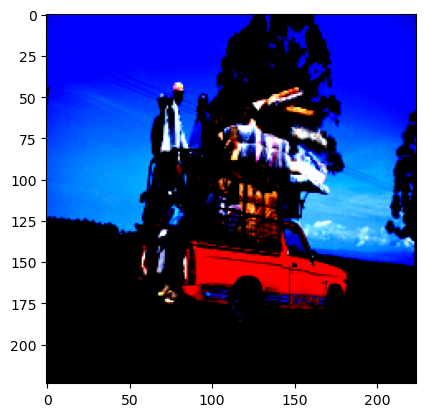

In [4]:
import matplotlib.pyplot as plt
for img,lab in zip(images,labels):
    plt.imshow(img.permute(1,2,0))
    indices = np.argwhere(lab > 0)
    print(indices)
    break

In [5]:
import os
import clip
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from itertools import permutations
from scipy.special import kl_div
import itertools
import numpy as np
import copy
import shutil

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# print(clip.available_models())
clip_model, preprocess = clip.load('RN50', device)
# clip_model = clip_model#.float()

In [8]:
def get_features(dataloader):
    all_features_batches = []
    all_labels_batches = []
    for images, labels in dataloader:
        features = clip_model.encode_image(images.to(device))
        all_features_batches.append(features.detach())
        all_labels_batches.append(labels)
    return all_features_batches, all_labels_batches

train_features, train_labels = get_features(train_loader)

In [9]:
train_features_path = "/home/samyakr2/multilabel/ARK/coco_train_clip_features_rn50.pt"
train_labels_path = '/home/samyakr2/multilabel/ARK/coco_train_clip_labels_rn50.pt'
# Save the tensor to file
torch.save(train_features, train_features_path)
torch.save(train_labels, train_labels_path)


In [10]:
phase = 'val'
root_dir = '/home/samyakr2/multilabel/data/coco/{}2017/'.format(phase)
dire = '/home/samyakr2/multilabel/data/coco'
annotation_file = '{}/annotations/instances_{}.json'.format(dire,phase+'2017') ## for val
coco_dataset = CocoDataset(root_dir=root_dir, annotation_file=annotation_file, transform=transform)

# Define DataLoader
batch_size = 32
val_loader = torch.utils.data.DataLoader(coco_dataset, batch_size=batch_size, shuffle=True)


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [16]:
val_features, val_labels = get_features(val_loader)

val_features_path = "/home/samyakr2/multilabel/ARK/coco_val_clip_features_rn50.pt"
val_labels_path = '/home/samyakr2/multilabel/ARK/coco_val_clip_labels_rn50.pt'

torch.save(val_features, val_features_path)
torch.save(val_labels, val_labels_path)

In [18]:
len(val_features)

157

In [19]:
157*32

5024

In [20]:
len(train_features)

3697

In [21]:
3697*32

118304